<a href="https://colab.research.google.com/github/bachaudhry/FastAI-22-23/blob/main/course_part_2/01A_Stable_Diffusion_Under_the_Hood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stable Diffusion - A Look Under the Hood**

I'll be attempting to better understand the mechanics of the Hugging Face diffusers library by re-creating [J. Whitaker's excellent run-through](https://github.com/fastai/diffusion-nbs/blob/master/Stable%20Diffusion%20Deep%20Dive.ipynb).

In [1]:
# Installing requirements for this NB
!pip install -q --upgrade transformers==4.25.1 diffusers ftfy accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.5 MB/s eta 0:00:00


In [2]:
from base64 import b64encode
from google.colab import userdata
userdata.get('HFtoken')

import numpy as np
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# Setup for Vid display
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os

torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Warning suppression when loading CLIPTextModel
logging.set_verbosity_error()

# Choose cuda or cpu, since we won't be requiring mps
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


0it [00:00, ?it/s]

## Load Models

GPU memory is an ever present concern. Let's work with the suggested work arounds in the original notebook i.e.:
1. Switch to `fp16`
2. Experiment with attention slicing
3. Keep VAE on the CPU

In [3]:
# Autoencoder model for decoding latents into the image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4",
                                    subfolder="vae")#, variant="fp16",
                                    #torch_dtype=torch.float16)

# Tokenizer and the text encoder to tokenize and encode the text
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")#,
                                          # variant="fp16")#,
                                          #torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")#.half() # convert to half precision

# UNet model to generate latents
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4",
                                            subfolder="unet")#, variant="fp16",
                                            #torch_dtype=torch.float16)

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012,
                                 beta_schedule="scaled_linear",
                                 num_train_timesteps=1000)

# Loading components onto the GPU and CPU
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)


vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

## Running a Diffusion Loop

In [4]:
# Starting off with settings
prompt = ["An oil on canvas painting of a Peace Lily"]
height = 512                      # Default height of Stable Diffusion
width = 512                       # Default width
num_inference_steps = 30          # Number of denoising steps
guidance_scale = 7.5              # Scale for classifier-free guidance
generator = torch.manual_seed(32) # Seed generator for initial latent noise
batch_size = 1

In [5]:
# Prep Text
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length,
                       truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)

with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [6]:
# Prep Scheduler
def set_timesteps(scheduler, num_inference_steps):
  scheduler.set_timesteps(num_inference_steps)
  scheduler.timesteps = scheduler.timesteps.to(torch.float32) # Needs Altering due to memory issues.

set_timesteps(scheduler, num_inference_steps)

In [7]:
# Prep latents
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator = generator
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma # This version introuces scaling

<ipython-input-7-742c79a3ec6c>:3: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

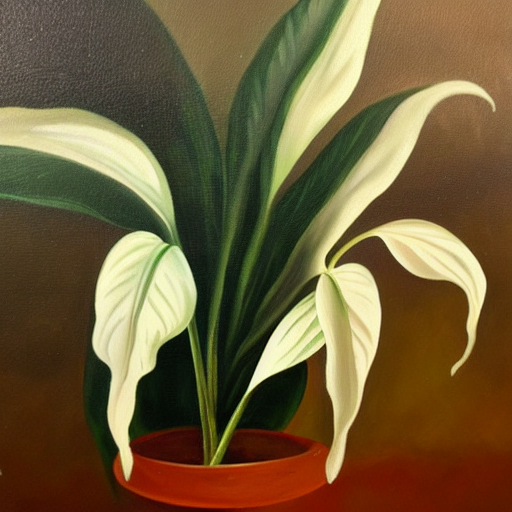

In [8]:
# Inference loop
with autocast("cuda"): # Reverts to CPU if there is no CUDA
  for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    # Expand the latents if we are applying classifier free guidance to avoid two forward passes
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    # Scale the latents (pre-conditioning)
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # Predict the noise residual
    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # Perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # Compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

# Scale and decode the image latents with vae
latents = 1 / 0.18215 * latents ## the scaling factor was implemented in the original paper.
with torch.no_grad():
  image = vae.decode(latents).sample

# Display output
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]


## The Autoencoder (AE)

The AE is used to encode an image into some form of latent representation, and then decode this back into an image.

In [9]:
def pil_to_latent(input_im):
  # Single image to single latent in a batch
  with torch.no_grad():
    latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2 - 1)
  # Scaling from before
  return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
  # batch of latents to list of images
  latents = (1 / 0.18215) * latents
  with torch.no_grad():
    image = vae.decode(latents).sample
  image = (image / 2 + 0.5).clamp(0, 1)
  image = image.detach().cpu().permute(0, 2, 3, 1).numpy() # For reference permute consists of (bs, h, w, ch)
  images = (image * 255).round().astype("uint8")
  pil_images = [Image.fromarray(image) for image in images]
  return pil_image

In [18]:
import os
os.chdir('/content/drive/MyDrive/Pic_samples/')
input_image = plt.imread('pasha.jpg')

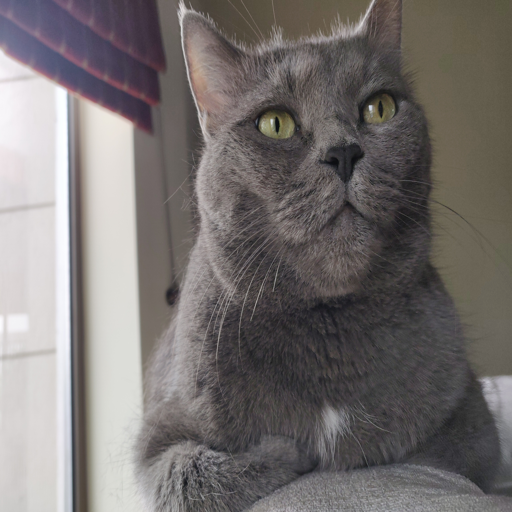

In [19]:
# Load the image
input_image = Image.open('pasha.jpg').resize((512, 512))
input_image

In [20]:
# Encoding to the latent space
encoded = pil_to_latent(input_image)
encoded.shape

torch.Size([1, 4, 64, 64])

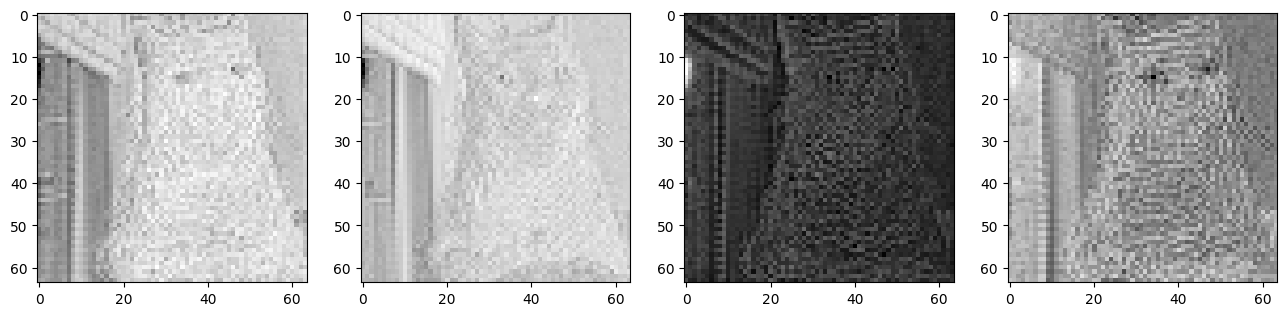

In [21]:
# Visualizing the channels
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
  axs[c].imshow(encoded[0][c].cpu(), cmap='Greys')